In [1]:
import pandas
import contextily
import geopandas
import math 

import numpy
from shapely import geometry
import geodesy

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
min_latitude = 47
min_longitude = 5.5
max_latitude = 55
max_longitude = 15


grid = geodesy.Grid(min_latitude, min_longitude, max_latitude, max_longitude, 100000, 3)

(latitude, longitude) = (48.1375, 11.575) # Munich
index_of_center = grid.index_of(latitude, longitude) 

( 
    index_of_center,
    sorted(list(grid.window(latitude, longitude, 200000)), key=lambda _:(_[0],_[1])), 
)



((5, 1),
 [(3, 0, 162173.57262789315),
  (3, 1, 143286.1291066923),
  (3, 2, 184835.5193520459),
  (4, 0, 94115.891345549),
  (4, 1, 58186.30492802488),
  (4, 2, 131601.13072103757),
  (5, 0, 83952.38540268004),
  (5, 1, 40082.609186983325),
  (5, 2, 124783.33608811011),
  (6, 0, 144469.03054989225),
  (6, 1, 123264.95453214172),
  (6, 2, 170060.76428335937)])

In [18]:

dynamic_grid = geodesy.DynamicGrid(min_latitude, min_longitude, max_latitude, max_longitude, 100)
dynamic_grid.index_of(latitude, longitude)

dynamic_grid.cell_at(index_of_center[0], index_of_center[1])['geometry'].exterior.coords.xy
window = (dynamic_grid.window(47.854444, 12.186111, 2000))
window

geometry     distance
i    j                                                                  
5030 943  POLYGON ((12.159 47.85089, 12.16033 47.85089, ...  1996.551352
     944  POLYGON ((12.159 47.85179, 12.16033 47.85179, ...  1981.767346
     945  POLYGON ((12.159 47.8527, 12.16033 47.8527, 12...  1971.949615
     946  POLYGON ((12.159 47.8536, 12.16033 47.8536, 12...  1967.172517
     947  POLYGON ((12.159 47.8545, 12.16033 47.8545, 12...  1967.472768
...                                                     ...          ...
5070 945  POLYGON ((12.21196 47.8527, 12.21328 47.8527, ...  1976.444771
     946  POLYGON ((12.21196 47.8536, 12.21328 47.8536, ...  1971.678485
     947  POLYGON ((12.21196 47.8545, 12.21328 47.8545, ...  1971.977972
     948  POLYGON ((12.21196 47.8554, 12.21328 47.8554, ...  1977.340930
     949  POLYGON ((12.21196 47.8563, 12.21328 47.8563, ...  1987.726375

[1274 rows x 2 columns]

In [12]:
number_of_samples = 1000
sample = numpy.random.random_sample((number_of_samples,2))
scale = numpy.array([
        (max_latitude - min_latitude),
        (max_longitude - min_longitude) 
            ])
offset = numpy.array([min_latitude, min_longitude])
coordinates = sample * scale + offset
points = geopandas.GeoDataFrame({"Geometry": geometry.Point(coordinate[1], coordinate[0])} for coordinate in coordinates).set_geometry("Geometry").set_crs(4326)

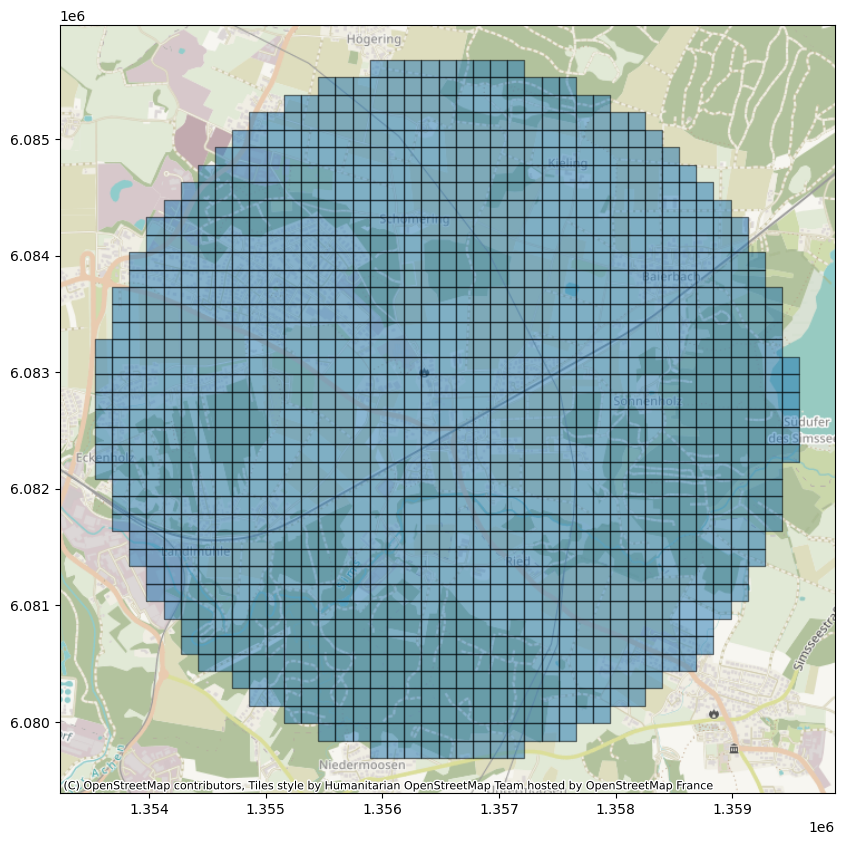

In [19]:
axes =  window.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")

contextily.add_basemap(axes,crs="epsg:3857")

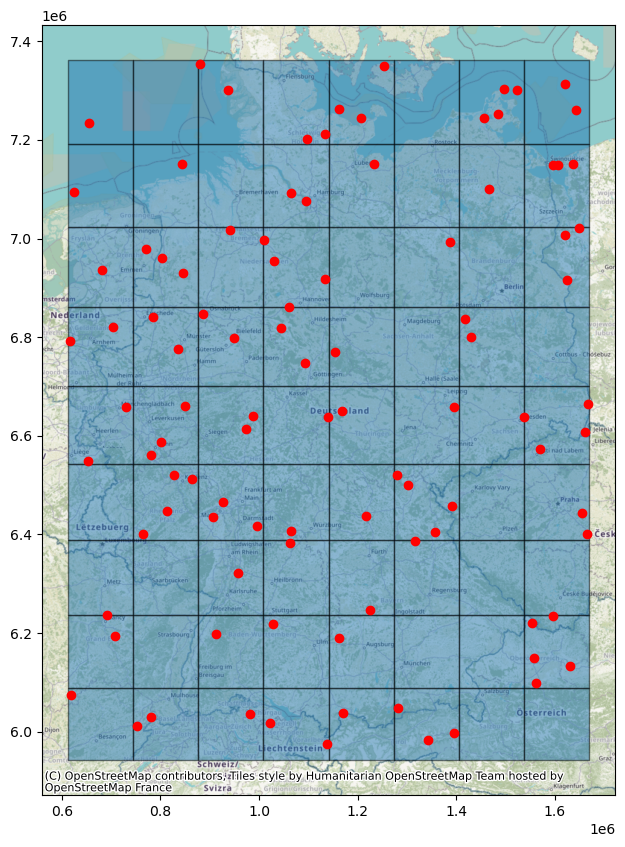

In [11]:
axes =  grid.geodataframe.to_crs(epsg=3857).plot(figsize=(10, 10), alpha=0.5, edgecolor="k")
points.to_crs(epsg=3857).plot(ax=axes, color="r")
contextily.add_basemap(axes,crs="epsg:3857")

In [13]:
%%time


with open("dump.csv", 'wt') as file:

    for (_,point) in points.iterrows():
        (longitude, latitude) = (point.Geometry.x, point.Geometry.y)
        for ((i,j), row) in (dynamic_grid.window(latitude, longitude, 1000)).iterrows():
            file.write(f"{i},{j},{row.distance}\n")

CPU times: user 1min 55s, sys: 1.09 s, total: 1min 56s
Wall time: 1min 57s
